In [68]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns

In [71]:
#load data
donor_df = pd.read_excel('Kids_help_phone.xlsx',sheet_name="Donors", index_col=None)

In [72]:
donor_df.head()

,Gift Type,Gift Amount,Gift Date,Campaign List,Gift Import ID,Constituent ID,Preferred Postal Code,Year,Month,Day of week
0,Pledge,1500.0,2019-04-29,NATEVT-O,00001-545-0002735862,33,NaN,2019,April,Monday
1,Pledge,1303.5,2012-05-06,NATEVT-N,00001-545-0002095526,1078531-PARENT,NaN,2012,May,Sunday
2,Pledge,890.0,2013-08-06,NATEVT-N,00001-545-0002226707,1078531-PARENT,NaN,2013,August,Tuesday
3,Pledge,909.5,2014-09-25,NATEVT-N,00001-545-0002326040,1078531-PARENT,NaN,2014,September,Thursday
4,Pledge,100.0,2017-04-18,NATEVT-O,00001-545-0002559691,11889902,NaN,2017,April,Tuesday


In [73]:
donor_df.dtypes

Gift Type                        object
Gift Amount                     float64
Gift Date                datetime64[ns]
Campaign List                    object
Gift Import ID                   object
Constituent ID                   object
Preferred Postal Code            object
Year                              int64
Month                            object
Day of week                      object
dtype: object

# build donor rfm model

In [74]:
#find min and max date
donor_df['Gift Date'].min()
donor_df['Gift Date'].max()

Timestamp('2019-09-30 00:00:00')

In [75]:
import datetime as dt
NOW = dt.datetime(2019,10,1)
donor_df['Gift Date'] = pd.to_datetime(donor_df['Gift Date'])

In [76]:
#rfm model
rfmTable = donor_df.groupby('Constituent ID').agg({'Gift Date': lambda x: (NOW - x.max()).days,
                                        'Gift Import ID': lambda x: len(x),  
                                        'Gift Amount': lambda x: x.sum()})

rfmTable['Gift Date'] = rfmTable['Gift Date'].astype(int)
rfmTable.rename(columns={'Gift Date': 'recency', 
                         'Gift Import ID': 'frequency', 
                         'Gift Amount': 'monetary_value'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary_value
Constituent ID,,,
33,155,1,1500.0
67,3088,2,1000.0
92,3086,1,200.0
186,491,1,300.0
211,1248,5,36000.0


In [82]:
#split quantiles
quantiles = rfmTable.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()

In [83]:
segmented_rfm = rfmTable

In [84]:
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5
    
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1

In [85]:
#segment the data
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
Constituent ID,,,,,,
33,155,1,1500.0,1,5,1
67,3088,2,1000.0,5,2,1
92,3086,1,200.0,5,5,1
186,491,1,300.0,1,5,1
211,1248,5,36000.0,2,1,1


In [86]:
#add rfm
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
Constituent ID,,,,,,,
33,155,1,1500.0,1,5,1,151
67,3088,2,1000.0,5,2,1,521
92,3086,1,200.0,5,5,1,551
186,491,1,300.0,1,5,1,151
211,1248,5,36000.0,2,1,1,211


In [87]:
#output
from datetime import date
from datetime import datetime
from datetime import timedelta 

current_time = datetime.now()
info = current_time.strftime('%m%d%Y')
output_filename = ("rfm_" + str(info[:4]) + str(info[6:]) + ".csv")
segmented_rfm.to_csv(output_filename, sep=',', header=True)

# LTV model

In [88]:
segmented_rfm2 = segmented_rfm[['recency','frequency','monetary_value']]

In [89]:
#rename columns
segmented_rfm2.columns=['num_days','num_transactions','spent_money']
segmented_rfm2.head()

,num_days,num_transactions,spent_money
Constituent ID,,,
33,155,1,1500.0
67,3088,2,1000.0
92,3086,1,200.0
186,491,1,300.0
211,1248,5,36000.0


In [23]:
#CLTV formula
#CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
#Customer Value = Average Order Value * Purchase Frequency

In [90]:
# Average Order Value
segmented_rfm2['avg_order_value']=segmented_rfm2['spent_money']/segmented_rfm2['num_transactions']

In [91]:
segmented_rfm2.head()

,num_days,num_transactions,spent_money,avg_order_value
Constituent ID,,,,
33,155,1,1500.0,1500.0
67,3088,2,1000.0,500.0
92,3086,1,200.0,200.0
186,491,1,300.0,300.0
211,1248,5,36000.0,7200.0


In [92]:
purchase_frequency=sum(segmented_rfm2['num_transactions'])/segmented_rfm2.shape[0]

In [93]:
repeat_rate=segmented_rfm2[segmented_rfm2.num_transactions > 1].shape[0]/segmented_rfm2.shape[0]

In [94]:
churn_rate=1-repeat_rate

In [95]:
#assume profit margin is 5%
segmented_rfm2['profit_margin']=1

In [96]:
# Customer Value
segmented_rfm2['CLV']=(segmented_rfm2['avg_order_value']*purchase_frequency)/churn_rate

In [97]:
#Customer Lifetime Value
segmented_rfm2['cust_lifetime_value']=segmented_rfm2['CLV']*segmented_rfm2['profit_margin']

In [98]:
segmented_rfm2.head()

,num_days,num_transactions,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
Constituent ID,,,,,,,
33,155,1,1500.0,1500.0,1,3091.603210,3091.603210
67,3088,2,1000.0,500.0,1,1030.534403,1030.534403
92,3086,1,200.0,200.0,1,412.213761,412.213761
186,491,1,300.0,300.0,1,618.320642,618.320642
211,1248,5,36000.0,7200.0,1,14839.695410,14839.695410


In [99]:
#output ltv model
current_time = datetime.now()
info = current_time.strftime('%m%d%Y')
output_filename = ("ltv_" + str(info[:4]) + str(info[6:]) + ".csv")
segmented_rfm2.to_csv(output_filename, sep=',', header=True)

# Cohort Analysis

In [ ]:
#cohort is a group of users sharing a particular characteristic. 
#Strictly speaking it can be any characteristic, but typically the term cohort refers to a time-dependent grouping. 
#For example, a typical cohort groups users by the week or month when they were first acquired. 
#When speaking of groupings that are not time-dependent, the term segment is typically used instead of cohort.
#A cohort analysis refers to tracking and investigating the performance of cohorts over time.

In [1]:
#https://www.appcues.com/blog/cohort-analysis
#https://www.cohortanalysis.com
#http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

In [100]:
import warnings
warnings.filterwarnings("ignore")

In [101]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
#load data
df = pd.read_excel('Kids_help_phone.xlsx',sheet_name="Donor2", index_col=None)

In [109]:
df.dtypes

Gift Type                        object
Gift Amount                     float64
Gift Date                datetime64[ns]
Campaign List                    object
Gift Import ID                   object
Constituent ID                   object
Preferred Postal Code            object
Year                              int64
Month                            object
Day of week                      object
dtype: object

In [110]:
df.columns=['GiftType','GiftAmount','GiftDate','CampaignList','GiftImportID','ConstistuentID','PreferredPostCode',
           'Year','Month','DayOfWeek']

In [111]:
#Create a period column based on the giftDate
df['GiftPeriod'] = df.GiftDate.apply(lambda x: x.strftime('%Y'))
df.head()

,GiftType,GiftAmount,GiftDate,CampaignList,GiftImportID,ConstistuentID,PreferredPostCode,Year,Month,DayOfWeek,GiftPeriod
0,Pledge,1500.0,2019-04-29,NATEVT-O,00001-545-0002735862,33,NaN,2019,April,Monday,2019
1,Pledge,1303.5,2012-05-06,NATEVT-N,00001-545-0002095526,1078531-PARENT,NaN,2012,May,Sunday,2012
2,Pledge,890.0,2013-08-06,NATEVT-N,00001-545-0002226707,1078531-PARENT,NaN,2013,August,Tuesday,2013
3,Pledge,909.5,2014-09-25,NATEVT-N,00001-545-0002326040,1078531-PARENT,NaN,2014,September,Thursday,2014
4,Pledge,100.0,2017-04-18,NATEVT-O,00001-545-0002559691,11889902,NaN,2017,April,Tuesday,2017


In [112]:
#Determine the user's cohort group (based on their first order)
df.set_index('ConstistuentID', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['GiftDate'].min().apply(lambda x: x.strftime('%Y'))
df.reset_index(inplace=True)
df.head()

,ConstistuentID,GiftType,GiftAmount,GiftDate,CampaignList,GiftImportID,PreferredPostCode,Year,Month,DayOfWeek,GiftPeriod,CohortGroup
0,33,Pledge,1500.0,2019-04-29,NATEVT-O,00001-545-0002735862,NaN,2019,April,Monday,2019,2019
1,1078531-PARENT,Pledge,1303.5,2012-05-06,NATEVT-N,00001-545-0002095526,NaN,2012,May,Sunday,2012,2012
2,1078531-PARENT,Pledge,890.0,2013-08-06,NATEVT-N,00001-545-0002226707,NaN,2013,August,Tuesday,2013,2012
3,1078531-PARENT,Pledge,909.5,2014-09-25,NATEVT-N,00001-545-0002326040,NaN,2014,September,Thursday,2014,2012
4,11889902,Pledge,100.0,2017-04-18,NATEVT-O,00001-545-0002559691,NaN,2017,April,Tuesday,2017,2016


In [113]:
#Rollup data by CohortGroup & OrderPeriod
grouped = df.groupby(['CohortGroup', 'GiftPeriod'])

# count the unique users, gifttype*, and gift amount + Period
cohorts = grouped.agg({'ConstistuentID': pd.Series.nunique,
                       'GiftImportID': pd.Series.nunique,
                       'GiftAmount': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'ConstistuentID': 'TotalUsers'}, inplace=True)
cohorts.head()

TotalUsers  GiftImportID  GiftAmount
CohortGroup GiftPeriod                                      
2010        2010             28699         33307  2040242.56
            2011              4713          5835   536380.41
            2012              3020          3707   417826.97
            2013              2252          2810   309518.65
            2014              1643          2136   283977.09

In [114]:
#Label the CohortPeriod for each CohortGroup
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first gift.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  GiftImportID  GiftAmount  CohortPeriod
CohortGroup GiftPeriod                                                    
2010        2010             28699         33307  2040242.56             1
            2011              4713          5835   536380.41             2
            2012              3020          3707   417826.97             3
            2013              2252          2810   309518.65             4
            2014              1643          2136   283977.09             5

In [124]:
cohorts.head(100)

GiftPeriod  TotalUsers  GiftImportID  GiftAmount
CohortGroup CohortPeriod                                                 
2010        1                  2010       28699         33307  2040242.56
            2                  2011        4713          5835   536380.41
            3                  2012        3020          3707   417826.97
            4                  2013        2252          2810   309518.65
            5                  2014        1643          2136   283977.09
            6                  2015        1323          1701   225670.46
            7                  2016        1066          1349   203286.07
            8                  2017         766           955   149735.50
            9                  2018         716           889   163103.25
            10                 2019         661           854   172944.16
2011        1                  2011       17153         19299  1101075.39
            2                  2012        2165          2496   186861.16
            3                  2013        1401          1624   139703.28
            4                  2014         986          1120    80657.70
            5                  2015         694           883    71561.89
            6                  2016         548           701    60324.37
            7                  2017         356           422    40477.25
            8                  2018         353           439    53959.66
            9                  2019         336           393    35379.55
2012        1                  2012       18032         20117  1258613.22
            2                  2013        1930          2168   288577.79
            3                  2014        1127          1255   191553.31
            4                  2015         872           976    99208.20
            5                  2016         535           624    77524.47
            6                  2017         419           488   126718.66
            7                  2018         340           385   124345.61
            8                  2019         300           341   113688.48
2013        1                  2013       23931         26802  1651004.57
            2                  2014        3411          4250   325843.91
            3                  2015        2386          2872   259285.95
            4                  2016        1926          2426   252239.92
            5                  2017        1642          2070   227889.16
            6                  2018        1433          1880   234546.41
            7                  2019        1198          1522   181826.36
2014        1                  2014       21797         24798  1702847.19
            2                  2015        3183          3679   307313.97
            3                  2016        2413          2875   279695.62
            4                  2017        1898          2308   237591.37
            5                  2018        1579          2007   249038.58
            6                  2019        1445          1793   206672.39
2015        1                  2015       19225         21985  1833353.02
            2                  2016        2621          3017   330058.74
            3                  2017        1893          2249   212364.69
            4                  2018        1579          1930   247547.12
            5                  2019        1250          1632   237079.39
2016        1                  2016       17453         19817  1732272.73
            2                  2017        2894          3351   430772.00
            3                  2018        2168          2503   214182.39
            4                  2019        1700          1984   189293.43
2017        1                  2017       15320         17786  1691395.37
            2                  2018        2332          2674   228716.88
            3                  2019        1698          1915   188205.59
2018        1                

In [115]:
#User Retention by Cohort Group
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2010    28699
2011    17153
2012    18032
2013    23931
2014    21797
Name: TotalUsers, dtype: int64

In [116]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2010         1               28699
             2                4713
             3                3020
             4                2252
             5                1643
Name: TotalUsers, dtype: int64

In [117]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
CohortPeriod,,,,,,,,,,
1,28699.0,17153.0,18032.0,23931.0,21797.0,19225.0,17453.0,15320.0,13063.0,14025.0
2,4713.0,2165.0,1930.0,3411.0,3183.0,2621.0,2894.0,2332.0,2194.0,NaN
3,3020.0,1401.0,1127.0,2386.0,2413.0,1893.0,2168.0,1698.0,NaN,NaN
4,2252.0,986.0,872.0,1926.0,1898.0,1579.0,1700.0,NaN,NaN,NaN
5,1643.0,694.0,535.0,1642.0,1579.0,1250.0,NaN,NaN,NaN,NaN


In [118]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
CohortPeriod,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.164222,0.126217,0.107032,0.142535,0.146029,0.136333,0.165817,0.152219,0.167955,NaN
3,0.105230,0.081677,0.062500,0.099703,0.110703,0.098466,0.124219,0.110836,NaN,NaN
4,0.078470,0.057483,0.048358,0.080481,0.087076,0.082133,0.097404,NaN,NaN,NaN
5,0.057249,0.040459,0.029669,0.068614,0.072441,0.065020,NaN,NaN,NaN,NaN
6,0.046099,0.031948,0.023236,0.059880,0.066294,NaN,NaN,NaN,NaN,NaN
7,0.037144,0.020754,0.018855,0.050061,NaN,NaN,NaN,NaN,NaN,NaN
8,0.026691,0.020579,0.016637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.024949,0.019588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
#output cohort
current_time = datetime.now()
info = current_time.strftime('%m%d%Y')
output_filename = ("cohort_" + str(info[:4]) + str(info[6:]) + ".csv")
cohorts.to_csv(output_filename, sep=',', header=True)

In [129]:
#output user rentention
current_time = datetime.now()
info = current_time.strftime('%m%d%Y')
output_filename = ("user_retention_" + str(info[:4]) + str(info[6:]) + ".csv")
user_retention.to_csv(output_filename, sep=',', header=True)

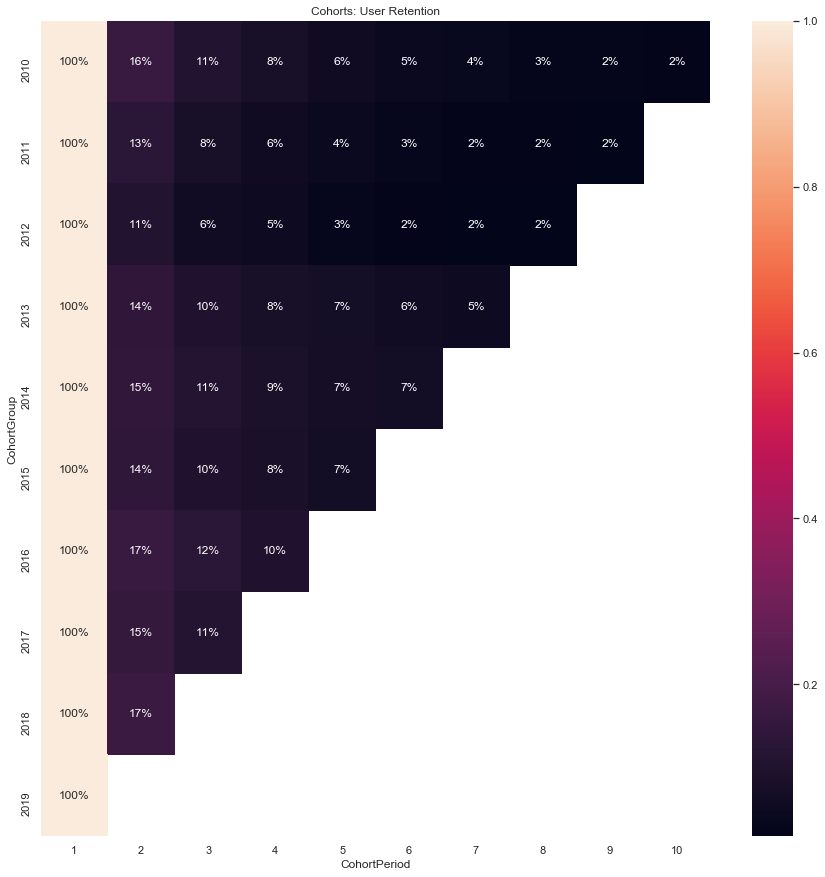

In [125]:
sns.set(style='white')
plt.figure(figsize=(15, 15))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

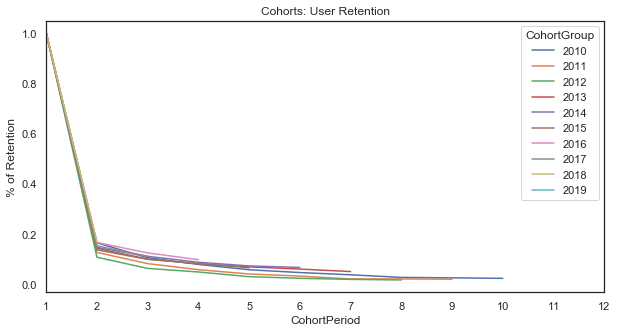

In [131]:
user_retention[['2010', '2011', '2012','2013', '2014', '2015','2016', '2017', '2018','2019']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Retention');